### Dataset

In [179]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop, SGD, AdamW, Nadam
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skopt import BayesSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import log_loss
from tensorflow.keras.metrics import AUC
from keras.utils import to_categorical
from adabound import AdaBound

In [180]:
# Evito que ciertas columnas se transformen a notacion cientifica en las predicciones
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

In [181]:
columns = [
    'Open_time',
    'Open',
    'High',
    'Low',
    # 'Close',
    'Number of trades',
    # 'Close_BTCUSDT',
    'Volume_BTCUSDT',
    'Number_of_trades_BTCUSDT',
    # 'Close_ETHUSDT',
    'Volume_ETHUSDT',
    # 'Number_of_trades_ETHUSDT',
    # 'Close_BNBUSDT',
    'Volume_BNBUSDT',
    # 'Number_of_trades_BNBUSDT',
    # 'SMA_20',
    'EMA_20',
    'Upper_Band',
    'Middle_Band',
    # 'Lower_Band',
    'RSI',
    # 'buy_1000x_high_coinbase',
    # 'sell_1000x_high_coinbase',
    'total_trades_coinbase',	
    'Tweets_Utilizados',
    'Tweets_Utilizados_coin',
    # 'Tweets_Utilizados_referentes',
    'Tweets_Utilizados_whale_alert',
    'Buy_1000x_high',
    'sell_1000x_high',
    # 'total_trades_binance'
]

### Armado y entrenamiento de un clasificador a partir de los datos originales

#### Modelo convolucional

In [182]:
complete_dataset = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/data-visualization/final_dataset.csv') 
classifier_dataset = complete_dataset[columns]
classifier_dataset['Open_time'] = pd.to_datetime(classifier_dataset['Open_time'])
classifier_dataset['Tendencia'] = complete_dataset['Tendencia']

clasifier_validation = classifier_dataset[-10:]
classifier_dataset = classifier_dataset[:-10]

In [183]:
display(classifier_dataset.tail())

,Open_time,Open,High,Low,Number of trades,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Volume_ETHUSDT,Volume_BNBUSDT,EMA_20,Upper_Band,Middle_Band,RSI,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,Tendencia
941,2024-04-25,6.93,7.00,6.70,71088.00,31341.46,1375324.00,352288.55,453745.52,7.45,9.08,7.43,38.83,33468.00,151,114,22.00,242.00,219.00,Lateral
942,2024-04-26,6.86,6.95,6.71,67383.00,27085.19,1025561.00,252522.65,302119.88,7.38,8.94,7.34,37.81,26619.00,117,106,14.00,292.00,324.00,Lateral
943,2024-04-27,6.76,6.87,6.51,64779.00,20933.06,912422.00,323811.19,268783.91,7.33,8.73,7.24,38.57,25565.00,101,138,7.00,248.00,179.00,Lateral
944,2024-04-28,6.81,6.95,6.69,43208.00,16949.20,790652.00,304766.01,258059.43,7.27,8.38,7.13,37.66,20954.00,82,106,13.00,173.00,165.00,Lateral
945,2024-04-29,6.73,6.83,6.47,63006.00,28150.23,1152296.00,421831.29,330474.01,7.20,8.08,7.03,36.02,33959.00,115,125,24.00,260.00,188.00,Bajista


In [184]:
classifier_dataset.shape

(946, 20)

In [185]:
X = classifier_dataset.drop(columns=["Tendencia", "Open_time"])
y = classifier_dataset["Tendencia"]

y = y.to_numpy().reshape(-1, 1)
onehot_encoder = OneHotEncoder(sparse=False)
y_one_hot = onehot_encoder.fit_transform(y)


In [186]:
# DESCOMENTAR PARA NORMALIZACION

# scaler = MinMaxScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_validation = clasifier_validation.drop(columns=["Tendencia", "Open_time"])
y_validation = clasifier_validation["Tendencia"]

X_validation_scaled = scaler.transform(X_validation)
y_validation = y_validation.to_numpy().reshape(-1, 1)
y_validation_one_hot = onehot_encoder.transform(y_validation)

In [187]:
display(y_one_hot)

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [188]:
# Function to create the model
def create_model(activation, units, dropout, learning_rate, l2_penalty, depth, optimizer='adam'):
    model = Sequential()
    model.add(Conv1D(units, kernel_size=3, activation=activation, input_shape=(len(X.columns), 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    for _ in range(depth - 1):
        model.add(Conv1D(units, kernel_size=3, activation=activation))
        model.add(MaxPooling1D(pool_size=2))
        model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(units, activation=activation, kernel_regularizer=l2(l2_penalty)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(units=3, activation='softmax'))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adamw':
        optimizer = AdamW(learning_rate=learning_rate)
    # elif optimizer == 'nadam':
    #     optimizer = Nadam(learning_rate=learning_rate)
    # elif optimizer == 'adabound':
    #     optimizer = AdaBound(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[AUC(name='auc')])
    return model


classifier = KerasClassifier(build_fn=create_model, verbose=0, activation='relu', units=50, dropout=0.2, learning_rate=0.1, l2_penalty=0.001, depth=2, optimizer='adam')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Define cross-validation
cv = TimeSeriesSplit(n_splits=5)

# Define parameter space
param_space = {
    'depth': [2],
    'activation': ['relu', 'tanh', 'swish', 'selu'],
    'units': [64, 128, 256, 512],
    'dropout': [0.1, 0.2, 0.3, 0.4],
    'learning_rate': [0.01, 0.001, 0.0001],
    'epochs': [10, 20, 30, 50, 100],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'adamw', 'rmsprop', 'sgd'],
    # 'optimizer': ['adam', , 'nadam', 'adabound'],
    'l2_penalty': [0.001, 0.01, 0.1]
}

def categorical_crossentropy_loss(estimator, X_test, y_test):
    y_pred = estimator.predict_proba(X_test)
    loss = log_loss(y_test, y_pred)
    return loss

# Perform Bayesian optimization
bayes_search = BayesSearchCV(classifier, param_space, scoring=categorical_crossentropy_loss, verbose=0, cv=cv)
bayes_result = bayes_search.fit(X_scaled, y_one_hot, callbacks=[early_stopping, reduce_lr])
# bayes_result = bayes_search.fit(X, y_one_hot, callbacks=[early_stopping, reduce_lr])


In [189]:
# Show best results
print("Best score:", bayes_result.best_score_)
print("Best parameters:", bayes_result.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
best_model = bayes_result.best_estimator_
best_model.fit(X_scaled, y_one_hot)
# best_model.fit(X, y_one_hot)

Best score: 4.5214545894719125
Best parameters: OrderedDict([('activation', 'swish'), ('batch_size', 128), ('depth', 2), ('dropout', 0.1), ('epochs', 100), ('l2_penalty', 0.001), ('learning_rate', 0.001), ('optimizer', 'rmsprop'), ('units', 512)])


KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7f83dc53ff70>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	activation=swish
	units=512
	dropout=0.1
	learning_rate=0.001
	l2_penalty=0.001
	depth=2
	class_weight=None
)

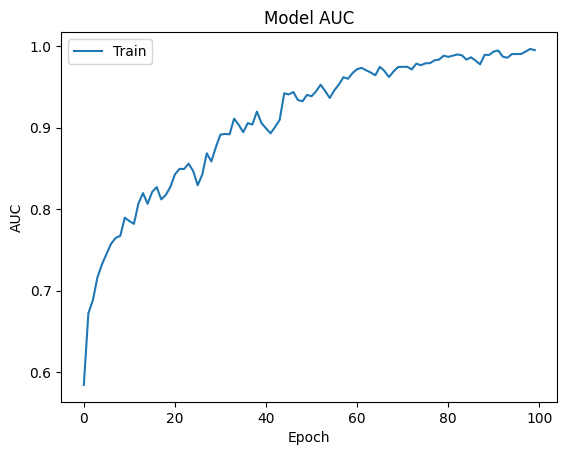

In [190]:
import matplotlib.pyplot as plt

history = bayes_result.best_estimator_.model_.history

plt.plot(history.history['auc'])
# plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [191]:
import json

# Obtener los hiperparámetros y puntajes de los 5 mejores modelos
top_n_models = 5
best_params_list = []
best_scores_list = []

if 'rank_test_score' in bayes_search.cv_results_:
    sorted_indices = np.argsort(bayes_search.cv_results_['rank_test_score'])

    for i in range(min(top_n_models, len(sorted_indices))):
        best_params_list.append(bayes_search.cv_results_['params'][sorted_indices[i]])
        best_scores_list.append(bayes_search.cv_results_['mean_test_score'][sorted_indices[i]])

    # Guardar los hiperparámetros de los 5 mejores modelos en un archivo JSON
    with open('conv_classifier/top_5_hyperparameters.json', 'w') as f:
        json.dump({'best_params': best_params_list, 'best_scores': best_scores_list}, f)

    # O imprimir los hiperparámetros
    print("Top 5 mejores modelos:")
    for i in range(len(best_params_list)):
        print("Modelo", i + 1)
        print("Hiperparámetros:", best_params_list[i])
        print("Puntaje:", best_scores_list[i])

else:
    print("Error: 'rank_test_score' no encontrado en cv_results_")


Top 5 mejores modelos:
Modelo 1
Hiperparámetros: OrderedDict([('activation', 'swish'), ('batch_size', 128), ('depth', 2), ('dropout', 0.1), ('epochs', 100), ('l2_penalty', 0.001), ('learning_rate', 0.001), ('optimizer', 'rmsprop'), ('units', 512)])
Puntaje: 4.5214545894719125
Modelo 2
Hiperparámetros: OrderedDict([('activation', 'swish'), ('batch_size', 32), ('depth', 2), ('dropout', 0.2), ('epochs', 100), ('l2_penalty', 0.001), ('learning_rate', 0.001), ('optimizer', 'rmsprop'), ('units', 256)])
Puntaje: 4.410993374685522
Modelo 3
Hiperparámetros: OrderedDict([('activation', 'swish'), ('batch_size', 128), ('depth', 2), ('dropout', 0.1), ('epochs', 100), ('l2_penalty', 0.001), ('learning_rate', 0.001), ('optimizer', 'adamw'), ('units', 512)])
Puntaje: 4.328679919882833
Modelo 4
Hiperparámetros: OrderedDict([('activation', 'swish'), ('batch_size', 128), ('depth', 2), ('dropout', 0.2), ('epochs', 100), ('l2_penalty', 0.001), ('learning_rate', 0.001), ('optimizer', 'rmsprop'), ('units', 5

#### Armado del ensamble

In [192]:
def generate_prime_seeds(n):
    seeds = []
    num = 70001  # Comenzamos desde el primer número primo mayor que 70000
    while len(seeds) < n:
        is_prime = True
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                is_prime = False
                break
        if is_prime:
            seeds.append(num)
        num += 1
    return seeds


In [193]:
## Clase personalizada para hacer el ensamble, dado que sklearn no provee ninguna clase que permita hacer ensmble
## de modelos re regresion multivariados
class MultivariableVotingClassifier:
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        # Hacer predicciones con cada modelo
        predictions = np.array([model.predict(X) for model in self.models])
        
        # Calcular la moda de las predicciones
        mode_predictions = np.argmax(np.sum(predictions, axis=0), axis=1)
        
        return mode_predictions


In [194]:

import json

# Leer los hiperparámetros desde el archivo JSON
with open('conv_classifier/top_5_hyperparameters.json', 'r') as f:
    top_hyperparameters = json.load(f)

prime_seeds = generate_prime_seeds(20)
models = []
best_seeds= {}

# Train models with different seeds for each set of hyperparameters
for mode_number, params in enumerate(top_hyperparameters['best_params']):
    best_validation_errors = {}
    
    for seed_number, seed in enumerate(prime_seeds):
        model = KerasClassifier(build_fn=create_model, random_state=seed, verbose=0, **params)
        model.fit(X_scaled, y_one_hot)
        # model.fit(X, y_one_hot)
        
        train_error = categorical_crossentropy_loss(model, X_scaled, y_one_hot)
        # train_error = categorical_crossentropy_loss(model, X, y_one_hot)
        
        mean_train_error = np.mean(train_error)
        
        # Update best validation error for this seed
        best_validation_errors[seed] = mean_train_error
        
        print(f"model number {mode_number}, seed number {seed_number}")
    
    # print("Best validation errors:", best_validation_errors)

    # Find the best seed for this set of hyperparameters
    best_seed_for_params = min(best_validation_errors, key=lambda k: best_validation_errors[k])
    best_seeds[str(params)] = best_seed_for_params
    
    # Create and train the model with the best seed
    model = KerasClassifier(build_fn=create_model, random_state=best_seed_for_params, verbose=0, **params)
    model.fit(X_scaled, y_one_hot)
    # model.fit(X, y_one_hot)
    
    models.append(model)

# Define and train the ensemble model
ensemble = MultivariableVotingClassifier(models)
ensemble.fit(X_scaled, y_one_hot)
# ensemble.fit(X, y_one_hot)

# Save the best seeds to a JSON file
with open('conv_classifier/best_seeds.json', 'w') as f:
    json.dump(best_seeds, f)


model number 0, seed number 0
model number 0, seed number 1
model number 0, seed number 2
model number 0, seed number 3
model number 0, seed number 4
model number 0, seed number 5
model number 0, seed number 6
model number 0, seed number 7
model number 0, seed number 8
model number 0, seed number 9
model number 0, seed number 10
model number 0, seed number 11
model number 0, seed number 12
model number 0, seed number 13
model number 0, seed number 14
model number 0, seed number 15
model number 0, seed number 16
model number 0, seed number 17
model number 0, seed number 18
model number 0, seed number 19
model number 1, seed number 0
model number 1, seed number 1
model number 1, seed number 2
model number 1, seed number 3
model number 1, seed number 4
model number 1, seed number 5
model number 1, seed number 6
model number 1, seed number 7
model number 1, seed number 8
model number 1, seed number 9
model number 1, seed number 10
model number 1, seed number 11
model number 1, seed number 

#### Clasificacion con el ensamble sobre las redicciones de los modelos generativos

In [195]:
with open('conv_classifier/best_seeds.json', 'r') as f:
    best_seeds = json.load(f)

# 21 Crear y entrenar los modelos con los hiperparámetros y semillas guardados
models = []
for params_str, seed in best_seeds.items():
    params = json.loads(params_str.replace("'", "\""))
    model = KerasClassifier(build_fn=create_model, random_state=seed, **params)
    model.fit(X_scaled, y_one_hot)
    # model.fit(X, y_one_hot)
    models.append(model)

Epoch 1/100
8/8 [==============================] - 3s 53ms/step - loss: 2.8787 - auc: 0.6067
Epoch 2/100
8/8 [==============================] - 1s 76ms/step - loss: 1.9066 - auc: 0.6499
Epoch 3/100
8/8 [==============================] - 0s 53ms/step - loss: 1.7757 - auc: 0.7072
Epoch 4/100
8/8 [==============================] - 0s 52ms/step - loss: 1.7456 - auc: 0.7107
Epoch 5/100
8/8 [==============================] - 1s 64ms/step - loss: 1.6936 - auc: 0.7364
Epoch 6/100
8/8 [==============================] - 0s 55ms/step - loss: 1.6719 - auc: 0.7418
Epoch 7/100
8/8 [==============================] - 0s 49ms/step - loss: 1.6272 - auc: 0.7623
Epoch 8/100
8/8 [==============================] - 0s 48ms/step - loss: 1.6261 - auc: 0.7473
Epoch 9/100
8/8 [==============================] - 0s 47ms/step - loss: 1.5958 - auc: 0.7618
Epoch 10/100
8/8 [==============================] - 0s 47ms/step - loss: 1.5170 - auc: 0.7915
Epoch 11/100
8/8 [==============================] - 0s 49ms/step - lo

In [196]:
ensemble = MultivariableVotingClassifier(models)
ensemble.fit(X_scaled, y_one_hot)
# ensemble.fit(X, y_one_hot)

Epoch 1/100
8/8 [==============================] - 3s 56ms/step - loss: 2.8787 - auc: 0.6067
Epoch 2/100
8/8 [==============================] - 1s 84ms/step - loss: 1.9066 - auc: 0.6499
Epoch 3/100
8/8 [==============================] - 0s 52ms/step - loss: 1.7757 - auc: 0.7072
Epoch 4/100
8/8 [==============================] - 0s 44ms/step - loss: 1.7456 - auc: 0.7107
Epoch 5/100
8/8 [==============================] - 0s 45ms/step - loss: 1.6936 - auc: 0.7364
Epoch 6/100
8/8 [==============================] - 0s 43ms/step - loss: 1.6719 - auc: 0.7418
Epoch 7/100
8/8 [==============================] - 0s 46ms/step - loss: 1.6272 - auc: 0.7623
Epoch 8/100
8/8 [==============================] - 0s 46ms/step - loss: 1.6261 - auc: 0.7473
Epoch 9/100
8/8 [==============================] - 1s 55ms/step - loss: 1.5958 - auc: 0.7618
Epoch 10/100
8/8 [==============================] - 0s 45ms/step - loss: 1.5170 - auc: 0.7915
Epoch 11/100
8/8 [==============================] - 0s 44ms/step - lo

##### Datos originales:

In [197]:
display(clasifier_validation)

,Open_time,Open,High,Low,Number of trades,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Volume_ETHUSDT,Volume_BNBUSDT,EMA_20,Upper_Band,Middle_Band,RSI,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,Tendencia
946,2024-04-30,6.59,6.67,6.04,115512.00,54947.66,1985671.00,561717.49,766513.45,7.13,7.80,6.93,34.18,48709.00,142,187,23.00,379.00,377.00,Bajista
947,2024-05-01,6.42,6.93,6.13,175570.00,81166.47,2401089.00,624963.78,669027.32,7.11,7.41,6.85,43.30,83718.00,130,177,36.00,327.00,340.00,Alcista
948,2024-05-02,6.90,7.41,6.69,109002.00,47583.82,1572898.00,365939.72,359794.32,7.12,7.42,6.85,49.27,61208.00,461,374,25.00,270.00,282.00,Alcista
949,2024-05-03,7.27,7.39,7.00,109634.00,43628.40,1558661.00,355825.84,342906.43,7.14,7.44,6.90,48.86,46255.00,573,474,22.00,386.00,635.00,Lateral
950,2024-05-04,7.24,7.28,7.11,71120.00,24368.69,1113509.00,196263.95,197129.25,7.13,7.46,6.91,46.98,34251.00,407,472,14.00,203.00,232.00,Bajista
951,2024-05-05,7.12,7.40,7.01,72928.00,18526.75,992921.00,218760.27,180458.24,7.15,7.51,6.94,50.00,29197.00,417,499,6.00,320.00,284.00,Alcista
952,2024-05-06,7.30,7.47,7.06,94264.00,34674.92,1392557.00,355135.30,278669.01,7.15,7.53,6.96,47.10,40027.00,482,531,25.00,339.00,249.00,Bajista
953,2024-05-07,7.12,7.29,6.98,64947.00,25598.79,1272898.00,298796.68,289488.71,7.13,7.52,6.98,45.10,31028.00,495,494,28.00,296.00,205.00,Bajista
954,2024-05-08,6.99,7.19,6.89,75550.00,26121.19,1415152.00,266934.81,297016.62,7.12,7.52,6.99,44.94,32040.00,426,494,24.00,230.00,177.00,Lateral
955,2024-05-09,6.98,7.09,6.78,75016.00,30660.81,1381957.00,238561.75,464857.60,7.11,7.52,7.01,46.32,29314.00,475,464,16.00,188.00,257.00,Lateral


In [198]:
n_clases = 3 

# DESCOMENTAR PARA NORMALIZACION
clasifier_validation_normalized = scaler.transform(clasifier_validation[columns].drop(columns=["Open_time"]))
validation_predictions = ensemble.predict(clasifier_validation_normalized)

# validation_predictions = clasifier_validation[columns].drop(columns=["Open_time"])
# validation_predictions = ensemble.predict(validation_predictions)

predicciones_one_hot = to_categorical(validation_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(validation_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 252ms/step


array([1, 1, 0, 0, 2, 2, 2, 1, 2, 2])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Bajista',
 'Bajista',
 'Alcista',
 'Alcista',
 'Lateral',
 'Lateral',
 'Lateral',
 'Bajista',
 'Lateral',
 'Lateral']

##### Datos generados por auto ml con prophet:

In [199]:
auto_ml_prophet_df = pd.read_csv('auto_timeseries_models_prophet/predicciones.csv')
auto_ml_prophet_df = auto_ml_prophet_df[columns].drop(columns=["Open_time"])

# DESCOMENTAR PARA NORMALIZACION
auto_ml_prophet_df_normalized = scaler.transform(auto_ml_prophet_df)
auto_mp_prophet_predictions = ensemble.predict(auto_ml_prophet_df_normalized)

# auto_mp_prophet_predictions = ensemble.predict(auto_ml_prophet_df)

predicciones_one_hot = to_categorical(auto_mp_prophet_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(auto_mp_prophet_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 62ms/step


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Lateral',
 'Lateral',
 'Lateral',
 'Lateral',
 'Lateral',
 'Lateral',
 'Lateral',
 'Lateral',
 'Lateral',
 'Lateral']

##### Datos generados por auto ml con stats:

In [200]:
auto_ml_stats_df = pd.read_csv('auto_timeseries_models/predicciones.csv')
auto_ml_stats_df = auto_ml_stats_df[columns].drop(columns=["Open_time"])

# DESCOMENTAR PARA NORMALIZACION
auto_ml_stats_df_normalized = scaler.transform(auto_ml_stats_df)
auto_mp_stats_predictions = ensemble.predict(auto_ml_stats_df_normalized)

# auto_mp_stats_predictions = ensemble.predict(auto_ml_stats_df)

predicciones_one_hot = to_categorical(auto_mp_stats_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(auto_mp_stats_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 48ms/step


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Bajista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista']

##### Datos generados por auto ml con modelos clasicos:

In [201]:
auto_ml_df = pd.read_csv('h2o_models/predicciones.csv')
auto_ml_df = auto_ml_df[columns].drop(columns=["Open_time"])

# DESCOMENTAR PARA NORMALIZACION
auto_ml_df_normalized = scaler.transform(auto_ml_df)
auto_mp_predictions = ensemble.predict(auto_ml_df_normalized)

# auto_mp_predictions = ensemble.predict(auto_ml_df)

predicciones_one_hot = to_categorical(auto_mp_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(auto_mp_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 110ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Bajista',
 'Bajista',
 'Bajista',
 'Bajista',
 'Bajista',
 'Bajista',
 'Bajista',
 'Bajista',
 'Bajista',
 'Bajista']

##### Datos generados por auto ml con skforecast:

In [202]:
skforecast_df = pd.read_csv('skforecast/predicciones.csv')
skforecast_df = skforecast_df[columns[1:]]

# DESCOMENTAR PARA NORMALIZACION
skforecast_df_normalized = scaler.transform(skforecast_df)
skforecast_predictions = ensemble.predict(skforecast_df_normalized)

# skforecast_predictions = ensemble.predict(skforecast_df)

predicciones_one_hot = to_categorical(skforecast_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(skforecast_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 56ms/step


array([1, 1, 0, 0, 2, 2, 2, 2, 2, 2])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Bajista',
 'Bajista',
 'Alcista',
 'Alcista',
 'Lateral',
 'Lateral',
 'Lateral',
 'Lateral',
 'Lateral',
 'Lateral']

### Analizo los features mas importantes

#### Permutation Feature Importance

El método de Permutation Feature Importance implica permutar las características del dataset y medir el impacto en el rendimiento del modelo. Esto se hace una característica a la vez. Puedes utilizar el siguiente código para calcular la importancia de las características usando este método:



##### v1

In [203]:
# import numpy as np
# from sklearn.metrics import accuracy_score

# def permutation_feature_importance(model, X, y, metric=accuracy_score, n_repeats=10):
#     base_score = metric(y, model.predict(X))
#     scores = np.zeros((X.shape[1], n_repeats))
    
#     for i in range(X.shape[1]):
#         for n in range(n_repeats):
#             X_permuted = X.copy()
#             np.random.shuffle(X_permuted[:, i])
#             permuted_score = metric(y, model.predict(X_permuted))
#             scores[i, n] = base_score - permuted_score
            
#     importances = np.mean(scores, axis=1)
#     return importances

# # Usa el ensemble model para obtener las importancias
# importances = permutation_feature_importance(ensemble, X.values, y)

# # Ordena las características por importancia
# feature_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)

# # Imprime las importancias
# for feature, importance in feature_importances:
#     print(f'Feature: {feature}, Importance: {importance}')


##### v2

#### SHAP (SHapley Additive exPlanations)

SHAP es una técnica avanzada que explica las predicciones de cualquier modelo basado en el cálculo de los valores de Shapley de la teoría de juegos. Puedes usar la librería shap para calcular las importancias:



In [204]:
# import shap

# # Crear un background dataset, usualmente se usa una muestra aleatoria de los datos de entrenamiento
# background = X.sample(n=100)

# # Crear el objeto explainer de SHAP
# explainer = shap.KernelExplainer(ensemble.predict, background)

# # Calcular los valores SHAP para el conjunto de datos completo
# shap_values = explainer.shap_values(X)

# # Visualizar las importancias de las características
# shap.summary_plot(shap_values, X)
